In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sessions = pd.read_json("data/sessions.jsonl", lines=True)
artists = pd.read_json("data/artists.jsonl", lines=True)
tracks = pd.read_json("data/tracks.jsonl", lines=True)
track_storage = pd.read_json("data/track_storage.jsonl", lines=True)
users = pd.read_json("data/users.jsonl", lines=True)
genres = tracks.join(artists.set_index('id')['genres'], on='id_artist', rsuffix='_author').set_index('id')['genres']


# Analiza braków

In [11]:
sessions.isnull().mean()

timestamp     0.0
user_id       0.0
track_id      0.0
event_type    0.0
session_id    0.0
dtype: float64

In [15]:
artists.isnull().mean()

id        0.0
name      0.0
genres    0.0
dtype: float64

In [9]:
tracks.isnull().mean()

id                  0.000000
name                0.000000
popularity          0.000000
duration_ms         0.000000
explicit            0.000000
id_artist           0.000000
release_date        0.000000
danceability        0.000000
energy              0.000000
key                 0.000000
mode                0.800028
loudness            0.000000
speechiness         0.000000
acousticness        0.000000
instrumentalness    0.000000
liveness            0.000000
valence             0.000000
tempo               0.000000
time_signature      0.000000
dtype: float64

In [12]:
track_storage.isnull().sum()

track_id         0
storage_class    0
daily_cost       0
dtype: int64

In [13]:
users.isnull().sum()

user_id             0
name                0
city                0
street              0
favourite_genres    0
premium_user        0
dtype: int64

# Analiza informatywnosci

In [115]:
ses = sessions[sessions['event_type'].isin(['play', 'skip', 'like'])]
user_sessions = ses.groupby(['session_id'])
cache = []
for _, session in user_sessions:
    session = session.reset_index()
    track_gr = session.reset_index().groupby(['track_id'])
    for _, track in track_gr:
        cache.append({
            'track_id': track['track_id'].values[0],
            'timestamp': min(track['timestamp'].values),
            'user_id': track['user_id'].values[0],
            'isliked': int('like' in track['event_type'].values),
            'isskipped': int('skip' in track['event_type'].values)
        })
target_df = pd.DataFrame(cache)
target_df = target_df.join(genres, on="track_id").join(tracks.set_index('id'), on="track_id").join(users.set_index('user_id'), on='user_id', rsuffix="_user")
target_df=target_df.drop(columns=[col for col in target_df.columns if 'id' in col])
target_df['common_genres_size']=target_df.apply(lambda x: len(set(x['genres']).intersection(x['favourite_genres'])), axis=1)
target_df=target_df.drop(columns=['genres', 'name', 'name_user', 'favourite_genres', 'mode'])

isliked,0,1
isskipped,,
0,6126,1947
1,3028,1263


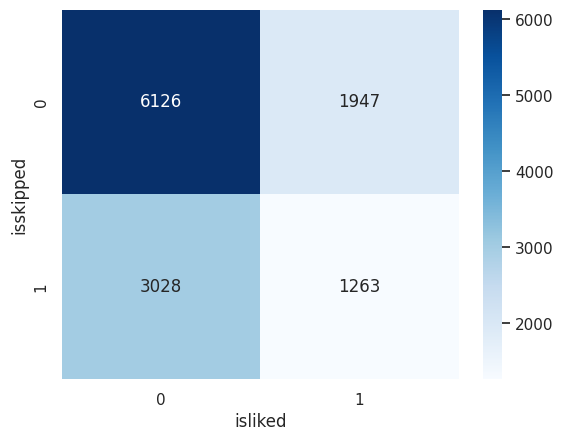

In [141]:
# target_df.drop(columns=['isskipped']).corrwith(target_df['isskipped'], numeric_only=True)
sns.heatmap(pd.crosstab(target_df['isskipped'], target_df['isliked']), annot=True, cmap='Blues', fmt='g')
pd.crosstab(target_df['isskipped'], target_df['isliked'])